In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install pretrainedmodels
!pip install git+https://github.com/qubvel/segmentation_models.pytorch
!pip install pytorch_toolbelt
!pip install torchvision==0.4


     |████████████████████████████████| 61kB 5.0MB/s eta 0:00:011
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=0c91e531e22d760e9ef7b82085f00892390e86319cff3011619623ed18f6463d
  Stored in directory: /tmp/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-dckyzs1k
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-dckyzs1k
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.0.2-cp36-none-any.whl size=27239 sha256=b961c16bb7e2dbf642af771772f7c48f17a8a2236b8ab306bb1e3475b7d770ae
  Stored in directory: /tmp/pip-ephem-wheel-cache-xwij5hp0/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
Successfully built segmentation-models-pytorch
     |████████████████████████████████| 61kB 5.

In [3]:
import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data.dataset import Dataset as Dataset
from torch.utils.data import dataloader as DL
from torch.autograd import Variable
from glob import glob
import cv2
import segmentation_models_pytorch as smp

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
input_folder = '../input'

train_paths = glob('/'.join([input_folder,'train/*.jpg']))
train_masks_paths = glob('/'.join([input_folder,'train_masks/*.gif']))
test_paths = glob('/'.join([input_folder,'test/*.jpg']))

train_paths.sort()
train_masks_paths.sort()
test_paths.sort()

temp1 = train_paths 
train_paths = train_paths[0:800]
val_paths = train_paths[801:1000]
temp2 = train_masks_paths
train_masks_paths = train_masks_paths[0:800]
val_masks_paths = train_masks_paths[801:1000]

test_paths = temp1[1100:1300]
test_masks_paths = temp2[1100:1300]

print('Number of training images: ', len(train_paths), 'Number of corresponding masks: ', len(train_masks_paths), 'Number of test images: ', len(test_paths))

Number of training images:  800 Number of corresponding masks:  800 Number of test images:  200


In [6]:
class CarsDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transforms, train=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transforms = transforms
        
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = self.transforms(image)
        mask = Image.open(self.mask_paths[idx])
        mask = self.transforms(mask)
        return image, mask
    
    def __len__(self):
        return len(self.image_paths)

In [7]:
img_size = 256

data_transforms=transforms.Compose([
                            transforms.Resize((img_size, img_size)),
                            transforms.ToTensor()]
)


train_dataset = CarsDataset(train_paths, train_masks_paths, transforms = data_transforms)
val_dataset = CarsDataset(val_paths, val_masks_paths, transforms = data_transforms )

In [8]:
%matplotlib inline
def show(img, normalize = False):
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg, interpolation='bicubic')

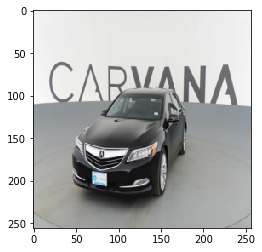

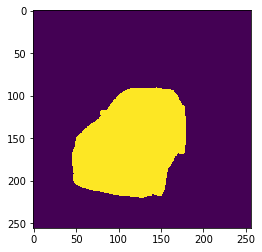

In [9]:
image, mask = train_dataset[1]
image = image.numpy()
image = np.transpose(image, (1, 2, 0))
mask = mask.numpy()
mask = np.transpose(mask, (1, 2, 0))
mask = np.resize(mask, (256, 256))
pair = [image, mask]
for img in pair:
    plt.figure()
    plt.imshow(img)

In [10]:
batch_size = 16

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False)

loaders = {
    "train": train_loader,
    "valid": valid_loader
}

In [11]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

ACTIVATION = None
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:06<00:00, 16.4MB/s]


In [17]:
num_epochs = 10
learning_rate = 0.001
logdir = "./logs/segmentation"

# model, criterion, optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=2)
#criterion = torch.nn.BCELoss()
criterion = smp.utils.losses.BCEDiceLoss(eps=1.)


In [13]:
#Number of parameters in the model
sum([p.numel() for p in model.parameters()])

32520977

In [14]:
dtype = torch.cuda.FloatTensor

In [18]:
#criterion = torch.nn.NLLLoss()
num_epochs = 10
running_loss = 0.0
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.type(torch.FloatTensor)
        masks = masks.to(device)        
        output = model(images)
        softmax = F.softmax(output, dim=1)
        loss = criterion(softmax, masks) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print (f"Epoch [{epoch + 1}/{num_epochs}], Step [{i}], Loss: {loss.item():4f}")

Epoch [1/10], Step [49], Loss: 2.310464
Epoch [2/10], Step [49], Loss: 2.310464
Epoch [3/10], Step [49], Loss: 2.310464
Epoch [4/10], Step [49], Loss: 2.310464
Epoch [5/10], Step [49], Loss: 2.310464
Epoch [6/10], Step [49], Loss: 2.310464
Epoch [7/10], Step [49], Loss: 2.310464
Epoch [8/10], Step [49], Loss: 2.310464
Epoch [9/10], Step [49], Loss: 2.310464
Epoch [10/10], Step [49], Loss: 2.310464


Predict

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


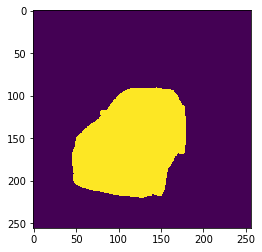

In [23]:
model.eval()

x, y = train_dataset[0]
x = x.unsqueeze(0)
x = x.cuda()
pred = model(x)
pred = pred.cpu().detach().numpy()
pred = np.resize(mask, (256, 256))
plt.imshow(pred)
print(pred)